# Continuos control

This project has been very hard. I tried an approach using the implementation approach I had used for project 1. It didn't work. It proved hard to train and unstable. I do think however that the chosen approach, which is to use a DDPG agent is a right one, as it worked in the end. But I discovered several flaws in the approach.

In summary:
- I needed a GPU to train this in sort of reasonable time
- Getting the hyperparameters right proved difficult

## The first tries

The regular approach didn't work. I saw some authors tweaking the discount rates and also, something that I implemented, to perform several updates to the network weights every time you do it. So there are two parameters, how often to update the weights (update_every) and how many times to update the weights.

I don't like this approach as it does feel not clean. You shoulnd't need to do it, specially if you have prioritized replay (which is a to-do point for me). It didn't work either.

These tries were done using AWS (Sagemaker) in a GPU, a lot of time was wasted here. I almost got it in an experiment that got to more than 29.5, but still didn't make it.

To generate these tries, use the ipynb notebooks under extras. They run with the code under the *continuous* folder.

In [1]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import mlflow
import pandas as pd
mlflow.set_tracking_uri('file:./mlruns')
mlflow.get_tracking_uri()
client = MlflowClient(tracking_uri='file:./mlruns')
experiment = client.get_experiment_by_name('continuous_1')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mlflow.exceptions import MlflowException
import numpy as np
import colorcet as cc
plt.style.use("seaborn-whitegrid")

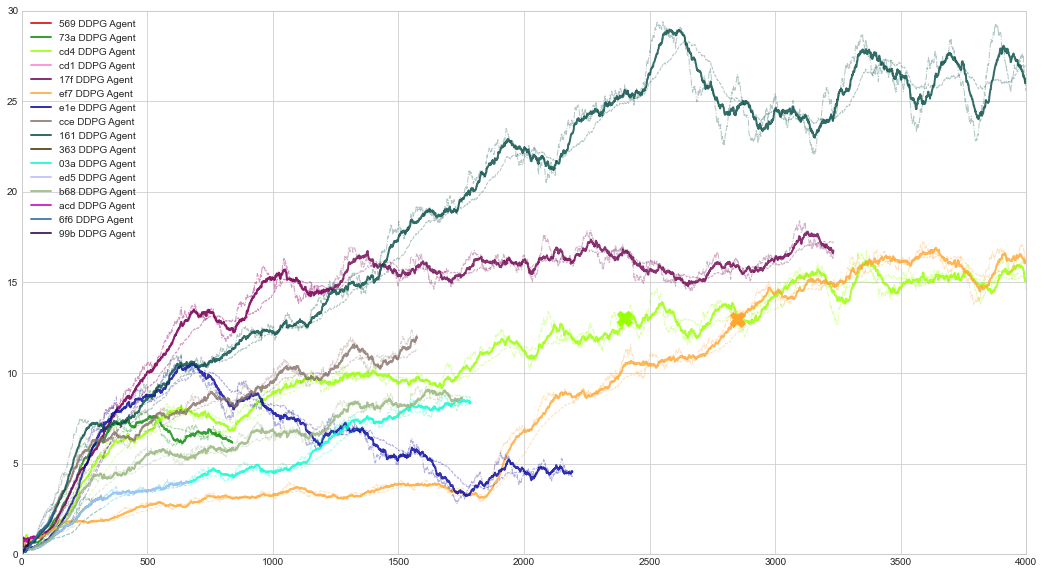

In [2]:
# The tries with the old implementation

runs = client.search_runs(experiment_ids=experiment.experiment_id)
plt.figure(figsize=(18,10))
x_lim = 0
for i, run in enumerate(runs):
    try:
        score = pd.DataFrame([ dict(m) for m in client.get_metric_history(run_id=run.info.run_id, key='score')])
        color = cc.glasbey_bw[i % len(cc.glasbey_bw)]
        x_lim = max(x_lim, score.step.max())
        if score.step.max() > 2000 or score.value.max() <= 10:
            pass
        #plt.plot(score.step, score.value, linewidth=0.5, color=color, alpha=0.05)
        plt.plot(score.step, score.value.rolling(100, min_periods=1).mean(), 
                 linewidth=2, color=color, alpha=0.8, linestyle='-', 
                 label=f'{run.info.run_id[:3]} {run.data.tags["mlflow.runName"]}')
        plt.plot(score.step, score.value.rolling(200, min_periods=1).mean(), 
                 linewidth=1, color=color, alpha=0.3, linestyle='--')
        plt.plot(score.step, score.value.rolling(50, min_periods=1).mean(), 
                 linewidth=1, color=color, alpha=0.3, linestyle='-.')

        if run.data.params.get('is_solved', 'False') == 'True':
            step_solved = run.data.metrics['episodes_to_solve']
            score_avg = score.loc[score.step<=step_solved, 'value'].rolling(100).mean().iloc[-1]
            plt.plot(step_solved, score_avg, marker='X', markersize=15, color=color)
    except MlflowException:
        pass
plt.xlim([0, 4000])
plt.ylim([0, 30])
plt.legend();

Almost there with one of the tries, but not quite. It is interesting to see that the 200-episode moving average is sometimes lower than the 100-episode moving average. There are performance cliffs.

Also, 2500 episodes looks like a lot, it shouldn't take that much.

## The actual code that worked

To make this work, I felt that MLflow was slowing things down, so you can find the implementation for this under *src/*. Now that I tried it, I am not quite sure this is true. Also, the code was hard to follow, so I took the simpler approach that I used for the tennis project.

The actual sequence of events is I tried to do this, I did not get it, I did the tennis project and came back to this project with a new implementation.

The new implementation is very similar to the old one in terms of what it actually does. But the code is simpler. Also, I found out that compared to other people I was:
- Using smaller networks than they were, so I switched to two layers from 512 and 256 units respectively.
- Not using batch normalization, so I switched to it.
- Not using dropout or leaky ReLUs, so I added a 20% dropout. I decided to stay with regular ReLUs.

I don't know which of these three modifications was responsible for the improvement but it did perform much better.

In [3]:
# All the code is under src/ so add it to the path first
import sys
sys.path.insert(0, 'src/')

# graphics
import matplotlib.pyplot as plt
%matplotlib inline

# Imports
from unityagents import UnityEnvironment
from config import Config
import torch
import numpy as np

In [4]:
# Change according to your platform or where you have the tennis environment. See README for details.
env = UnityEnvironment(file_name='extras/Reacher_one.app')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
env_info = env.reset(train_mode=True)[brain_name]

### Configuration

Set up the way agents will be trained and parameters for their networks. A better work could be done with some hyperparameter exploration and tracking (like I did in the other projects).

The configuration that worked for me (almost exactly the same as I used for tennis, interesting):

- 2 hidden layers with 512 and 256 hidden units for both actor and critic
- Replay batch size 512
- Buffer size 1e6
- Replay without prioritization
- Update frequency (update_every) 4
- Learning rate 1e-4 for actor and 3e-4 for critic
- Ornstein-Uhlenbeck noise (theta=0.15 and sigma=0.2)
- 20% dropout for critic

In [6]:
from memory import ReplayBuffer
from network import Actor, Critic
from noise import OUNoise

config = Config()

config.seed = 0
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.action_size = brain.vector_action_space_size
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)

config.actor_hidden_units = (512, 256)
config.actor_learning_rate = 1e-4
config.actor_network = lambda: Actor(config.action_size, config.state_size, config.actor_hidden_units, config.seed).to(config.device)
config.actor_optimizer = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_hidden_units = (512, 256)
config.critic_learning_rate = 3e-4
config.weight_decay = 0
config.critic_network = lambda: Critic(config.action_size, config.state_size, config.critic_hidden_units, config.seed).to(config.device)
config.critic_optimizer = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)

config.batch_size = 512
config.buffer_size = int(1e6)
config.discount = 0.99
config.update_every = 4
config.memory = lambda: ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.seed, config.device)

config.noise = lambda: OUNoise(config.action_size, config.seed)

In [7]:
from ddpg_agent import DDPGAgent
agent = DDPGAgent(config)

In [8]:
from collections import deque
def ddpg(n_episodes=2000, max_t=2000):
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for _ in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
                
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

Episode 1	Average Score: 1.21
Environment solved in 673 episodes!	Average Score: 30.03

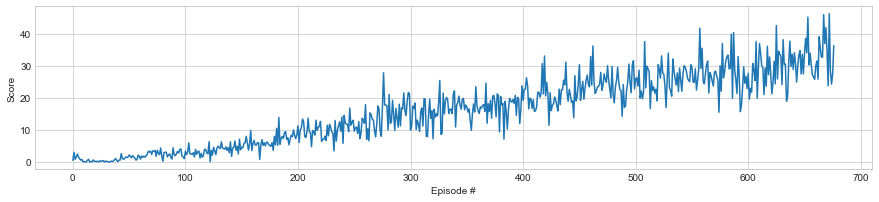

In [9]:
scores = ddpg()
# plot the scores
plt.figure(figsize=(15,3))
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
env.close()

## Comparison

Let's repeat the graphic from above and overlay this new one to see how much better this was.

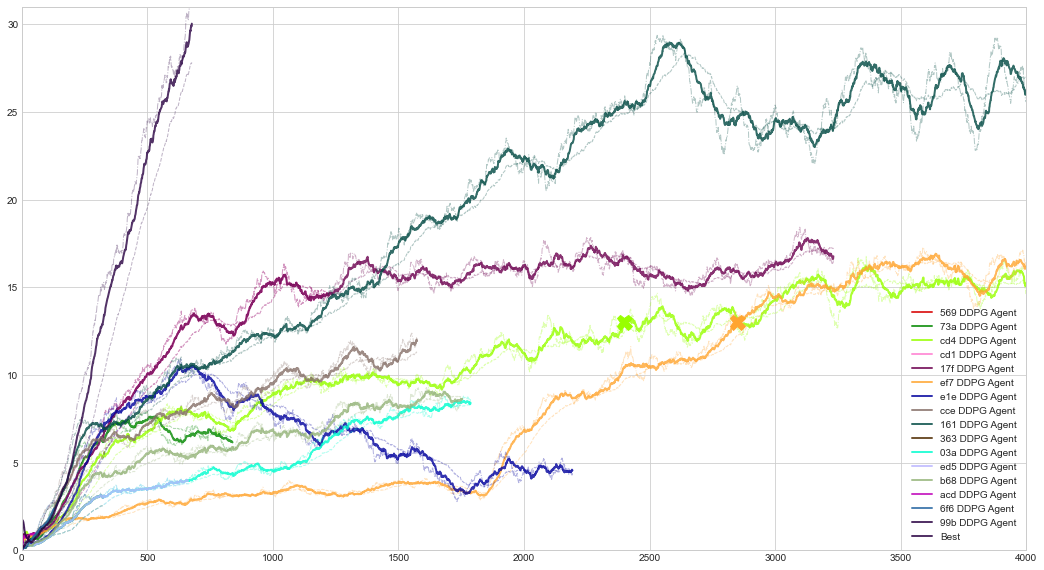

In [10]:
# The tries with the old implementation
import pandas as pd
runs = client.search_runs(experiment_ids=experiment.experiment_id)
plt.figure(figsize=(18,10))
x_lim = 0
for i, run in enumerate(runs):
    try:
        score = pd.DataFrame([ dict(m) for m in client.get_metric_history(run_id=run.info.run_id, key='score')])
        color = cc.glasbey_bw[i % len(cc.glasbey_bw)]
        x_lim = max(x_lim, score.step.max())
        if score.step.max() > 2000 or score.value.max() <= 10:
            pass
        #plt.plot(score.step, score.value, linewidth=0.5, color=color, alpha=0.05)
        plt.plot(score.step, score.value.rolling(100, min_periods=1).mean(), 
                 linewidth=2, color=color, alpha=0.8, linestyle='-', 
                 label=f'{run.info.run_id[:3]} {run.data.tags["mlflow.runName"]}')
        plt.plot(score.step, score.value.rolling(200, min_periods=1).mean(), 
                 linewidth=1, color=color, alpha=0.3, linestyle='--')
        plt.plot(score.step, score.value.rolling(50, min_periods=1).mean(), 
                 linewidth=1, color=color, alpha=0.3, linestyle='-.')

        if run.data.params.get('is_solved', 'False') == 'True':
            step_solved = run.data.metrics['episodes_to_solve']
            score_avg = score.loc[score.step<=step_solved, 'value'].rolling(100).mean().iloc[-1]
            plt.plot(step_solved, score_avg, marker='X', markersize=15, color=color)
    except MlflowException:
        pass
    
# Add the last run
score = pd.Series(scores)
step = np.arange(1, len(scores) + 1)
plt.plot(step, score.rolling(100, min_periods=1).mean(), 
         linewidth=2, color=color, alpha=0.8, linestyle='-', 
         label=f'Best')
plt.plot(step, score.rolling(200, min_periods=1).mean(), 
         linewidth=1, color=color, alpha=0.3, linestyle='--')
plt.plot(step, score.rolling(50, min_periods=1).mean(), 
         linewidth=1, color=color, alpha=0.3, linestyle='-.')

plt.xlim([0, 4000])
plt.ylim([0, 31])
plt.legend();

# Final thoughts

Switching from the complicated implementation to a simpler one like the one I used for tennis (yes, I did the tennis project before this on), is a good thing. [This implementation](https://github.com/ShangtongZhang/DeepRL) of algorithms is really good and easier to follow than the one I had. I was inspired by it.

Even though it worked, technically more things could be done in order to make this more interesting for more difficult problems.

- Make it possible to load configuration from a file, to improve (re)usability and experiment reproducibility
- Make the configuration part of the training itself rather than part of the agent, that way it would be easier to train the agent in an interactive way by tweaking hyperparameters.
- Use the multi-agent environments where there are 20 robotic arms, I think that way the GPU would have not been underutilized (it was roughly at 30% using a K80 from AWS)
- Add MLflow support to the second implementation (the one that worked), maybe making it somewhat agnostic by providing callback options in an extra thread for logging or something like that.

And on the reinforcement learning side:
- Prioritized replay. I never got to implement it, it is something that serves every learning algorithm.
- Metaparameter exploration for the agents and for the noise.
